In [144]:
import numpy as np
import pandas as pd
#import geopandas as gp
import matplotlib.pyplot as plt
import folium
import json
from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

In [2]:
nl_covid = pd.read_csv('../data/Raw/corona/nl_corona.csv',sep='\t')
weather = pd.read_csv('../data/Raw/weather/weather.csv',sep='\t')
with open('../data/Raw/metadata/nl_metadata.json') as f:
    metadata = json.load(f)
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df
#missing data?
#print(nl_weather_df.isna().any().any())
nl_weather_df
reg_dict = {}
names = {}
for i in metadata['country_metadata']:
    reg_dict[int(i['covid_region_code'])] = [i['population']]
    names[int(i['covid_region_code'])] = i['iso3166-2_code']
    

reg_names = set(nl_covid['region_code'])
mask1 = nl_covid['confirmed_addition'].dropna()
mask_idk = nl_covid['confirmed_addition'].notnull()

#print(4344-sum(mask_idk))
for i in list(reg_names):
    mask = (nl_covid['region_code'] == i) & (nl_covid['confirmed_addition'].notnull())
    mask_covid=nl_covid[mask]
    reg_dict[i].append(sum(mask_covid['confirmed_addition']))
df1 = pd.DataFrame.from_dict(reg_dict)
df1 = df1.transpose()
final_df = df1.rename(names)

In [3]:
nl_covid

,date,region_name,region_code,deceased_addition,confirmed_addition,hospitalized_addition,deceased_cumulative,confirmed_cumulative,hospitalized_cumulative
0,2020-02-27,Drenthe,22,NaN,NaN,NaN,NaN,0,NaN
1,2020-02-27,Flevoland,24,NaN,NaN,NaN,NaN,0,NaN
2,2020-02-27,Friesland,21,NaN,NaN,NaN,NaN,0,NaN
3,2020-02-27,Gelderland,25,NaN,NaN,NaN,NaN,0,NaN
4,2020-02-27,Groningen,20,NaN,NaN,NaN,NaN,0,NaN
...,...,...,...,...,...,...,...,...,...
4339,2021-02-22,Noord-Holland,27,6.0,821.0,12.0,2206.0,180576,3666.0
4340,2021-02-22,Overijssel,23,1.0,197.0,2.0,1018.0,74359,1125.0
4341,2021-02-22,Utrecht,26,1.0,291.0,4.0,1111.0,84449,1971.0
4342,2021-02-22,Zeeland,29,1.0,77.0,1.0,171.0,15987,456.0


In [4]:
'''Finding min, median, max and mean for each numerical value, for each region in the Netherlands.'''
#print(nl_weather_df['iso3166-2'].unique())
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
reg_dict = {}
for i in nl_weather_df['iso3166-2'].unique():
    reg_dict[i] = {}
    for j in num_columns:
        reg_dict[i][j] = {'min': min(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'median':np.median(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'max':max(nl_weather_df[nl_weather_df['iso3166-2'] == i][j]),'mean':np.mean(nl_weather_df[nl_weather_df['iso3166-2'] == i][j])}
#reg_dict['NL-GE']['RelativeHumiditySurface']

In [5]:
num_columns = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']
date_dict = {}
for i in nl_weather_df['date'].unique():
    date_dict[i] = {}
    for j in num_columns:
        date_dict[i][j] = np.mean(nl_weather_df[nl_weather_df['date'] == i][j])
#date_dict

<BarContainer object of 12 artists>

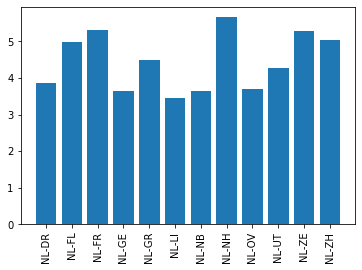

In [6]:
#Plotting means of windspeeds for different regions
means = [reg_dict[i]['WindSpeed']['mean'] for i in reg_dict.keys()]

plt.xticks(rotation=90)
plt.bar(reg_dict.keys(),means)

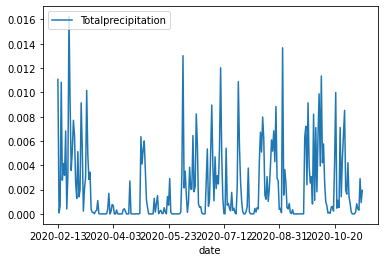

In [7]:
weather_by_day_nl = nl_weather_df.groupby(by = "date").mean()

weather_by_day_nl.loc[:, "Totalprecipitation"].plot.line().legend(loc = "upper left")

In [8]:
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.GeoJson('../Data/Raw/shapefiles/nl.geojson', name = "geojson").add_to(nl_map)
folium.LayerControl().add_to(nl_map)

nl_map

In [9]:
final_df.columns = ['population', 'cases']

In [10]:
df = final_df.reset_index()
df.columns = ["region",'population', 'cases']
df

,region,population,cases
0,NL-DR,493657.0,21039.0
1,NL-FL,422979.0,25315.0
2,NL-FR,649944.0,25271.0
3,NL-GE,2086142.0,119495.0
4,NL-GR,586061.0,23161.0
5,NL-LI,1117164.0,69949.0
6,NL-NB,2563432.0,166862.0
7,NL-NH,2879611.0,180576.0
8,NL-OV,1162500.0,74359.0
9,NL-UT,1354979.0,84449.0


In [11]:
# Third task, mapping the number of cases in a choropeth map
# We start by initializing the folium map
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)

# Then we use the Choropleth function, which requires: the path to the geoJSON (the shapes),
# a name for the layer, the dataframe containing the data, the columns we want to focus on,
# the attribute from the geoJSON which we use to map the data with the corresponding geometry
# in our case this is the iso code. Finally, we specify the color map, and the opacity (so that
# we can still see the map beneath), and a title.
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "cases",
    data = df,
    columns = ['region', 'cases'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of Cases",
).add_to(nl_map)

nl_map

In [12]:
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)

folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "cases",
    data = df,
    columns = ['region', 'population'],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "population",
).add_to(nl_map)

nl_map

In [13]:
# Fifth task, we create a new column in our data frame with the cases per capita
df["cases_pc"] = df["cases"] / df["population"]*100

# And we plot it just like we did before
nl_map = folium.Map(location = [52.3,5.5], zoom_start = 7.4)
folium.Choropleth(
    geo_data = '../Data/Raw/shapefiles/nl.geojson',
    name = "cases",
    data = df,
    columns = ['region', 'cases_pc'],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "number of cases %",
).add_to(nl_map)

nl_map

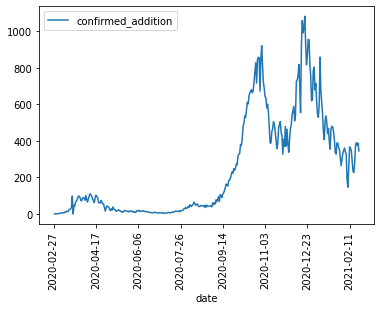

In [14]:
nl_covid_by_day =  nl_covid.groupby(by='date').mean()

nl_covid_by_day.loc[:,'confirmed_addition'].plot.line(rot=90).legend(loc='upper left')

#nl_covid_by_day.iloc[:,'confirmed_addition'].plot.line()

In [23]:
with open('../data/Raw/metadata/nl_metadata.json') as f:
    metadata = json.load(f)
nl_weather = weather['iso3166-2'].str[:2] == 'NL'
nl_weather_df = weather[nl_weather]
nl_weather_df
#missing data?
#print(nl_weather_df.isna().any().any())
nl_weather_df
reg_dict = {}
names = {}
for i in metadata['country_metadata']:
    reg_dict[int(i['covid_region_code'])] = [i['population']]
    names[int(i['covid_region_code'])] = i['iso3166-2_code']
    

reg_names = set(nl_covid['region_code'])
mask1 = nl_covid['confirmed_addition'].dropna()
mask_idk = nl_covid['confirmed_addition'].notnull()

#print(4344-sum(mask_idk))
for i in list(reg_names):
    mask = (nl_covid['region_code'] == i) & (nl_covid['confirmed_addition'].notnull())
    mask_covid=nl_covid[mask]
    reg_dict[i].append(sum(mask_covid['confirmed_addition']))
df1 = pd.DataFrame.from_dict(reg_dict)
df1 = df1.transpose()
final_df = df1.rename(names)

In [63]:
mask = nl_covid['confirmed_addition'].notnull()
nl_covid_clean = nl_covid[mask]
nl_covid_clean = nl_covid_clean.drop(['deceased_addition','hospitalized_addition','deceased_cumulative','confirmed_cumulative','hospitalized_cumulative'], axis=1)
nl_covid_clean

,date,region_name,region_code,confirmed_addition
12,2020-02-28,Drenthe,22,0.0
13,2020-02-28,Flevoland,24,0.0
14,2020-02-28,Friesland,21,0.0
15,2020-02-28,Gelderland,25,0.0
16,2020-02-28,Groningen,20,0.0
...,...,...,...,...
4339,2021-02-22,Noord-Holland,27,821.0
4340,2021-02-22,Overijssel,23,197.0
4341,2021-02-22,Utrecht,26,291.0
4342,2021-02-22,Zeeland,29,77.0


In [75]:
region_codes = set(nl_covid_clean['region_code'])

nl_covid_clean['region_code'].replace(list(names.keys()), list(names.values()), inplace=True)
nl_covid_clean

,date,region_name,region_code,confirmed_addition
12,2020-02-28,Drenthe,NL-DR,0.0
13,2020-02-28,Flevoland,NL-FL,0.0
14,2020-02-28,Friesland,NL-FR,0.0
15,2020-02-28,Gelderland,NL-GE,0.0
16,2020-02-28,Groningen,NL-GR,0.0
...,...,...,...,...
4339,2021-02-22,Noord-Holland,NL-NH,821.0
4340,2021-02-22,Overijssel,NL-OV,197.0
4341,2021-02-22,Utrecht,NL-UT,291.0
4342,2021-02-22,Zeeland,NL-ZE,77.0


In [125]:
#merge

weather_corona = nl_covid_clean.merge(nl_weather_df, left_on=['date','region_code'],right_on=['date','iso3166-2'])
weather_corona.drop(['region_code'],axis=1)

print(nl_covid_clean.shape[0] - weather_corona.shape[0])
print(nl_weather_df.shape[0] - weather_corona.shape[0])
weather_corona

1200
180


,date,region_name,region_code,confirmed_addition,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-28,Drenthe,NL-DR,0.0,NL-DR,85.273843,2.928512e+06,2.418883e+06,276.640094,0.006936,5.311518,5.604625
1,2020-02-28,Flevoland,NL-FL,0.0,NL-FL,84.473753,1.768177e+06,2.419984e+06,277.652467,0.006982,4.339130,7.142621
2,2020-02-28,Friesland,NL-FR,0.0,NL-FR,83.733823,2.235102e+06,2.418199e+06,277.660126,0.009203,4.835275,7.593261
3,2020-02-28,Gelderland,NL-GE,0.0,NL-GE,85.451835,2.148558e+06,2.419307e+06,276.989081,0.005471,5.283174,5.430404
4,2020-02-28,Groningen,NL-GR,0.0,NL-GR,83.629892,3.309977e+06,2.419139e+06,277.065390,0.008450,5.784530,6.361245
...,...,...,...,...,...,...,...,...,...,...,...,...
3127,2020-11-14,Noord-Holland,NL-NH,890.0,NL-NH,90.139789,3.315327e+05,2.428772e+06,284.412821,0.002788,0.022989,5.937843
3128,2020-11-14,Overijssel,NL-OV,357.0,NL-OV,90.624991,8.355392e+05,2.428846e+06,284.984318,0.001212,0.434870,3.534711
3129,2020-11-14,Utrecht,NL-UT,427.0,NL-UT,89.424252,9.894519e+05,2.429694e+06,285.008331,0.002306,0.135371,4.576365
3130,2020-11-14,Zeeland,NL-ZE,80.0,NL-ZE,87.590779,1.583508e+06,2.429062e+06,285.820956,0.002250,2.522796,6.111993


In [143]:
num_columns

withoutzeros = weather_corona["confirmed_addition"].clip(lower=1)

for var in num_columns:
    corr,p = pearsonr(weather_corona['confirmed_addition'],weather_corona[var])
    corr2,p2 = spearmanr(weather_corona['confirmed_addition'],weather_corona[var])
    corr3,p3 = pearsonr(np.log(withoutzeros),weather_corona[var])
    print('------------ '+var+' --------------')
    print("-----Pearson------")
    print("Correlation",corr)
    print("P value",p)
    print("-----Spearman------")
    print("Correlation", corr2)
    print("P value", p2)
    print("------LOG-------")
    print("Correlation", corr3)
    print("P value", p3)
    print('\n')

------------ RelativeHumiditySurface --------------
-----Pearson------
Correlation 0.2591448504589751
P value 3.088635268628318e-49
-----Spearman------
Correlation 0.17119846530118615
P value 4.9886821071058895e-22
------LOG-------
Correlation 0.1473097030638071
P value 1.17090413848579e-16


------------ SolarRadiation --------------
-----Pearson------
Correlation -0.3031720996839442
P value 1.3813892518461925e-67
-----Spearman------
Correlation -0.24919847742881215
P value 1.515594304489898e-45
------LOG-------
Correlation -0.25931240953271156
P value 2.668028118846419e-49


------------ Surfacepressure --------------
-----Pearson------
Correlation -0.04955965853428121
P value 0.005534310881026885
-----Spearman------
Correlation 0.027537562453286663
P value 0.12336627487089394
------LOG-------
Correlation 0.010111651853898803
P value 0.5716114514402791


------------ TemperatureAboveGround --------------
-----Pearson------
Correlation -0.14922064510328945
P value 4.669623739309128e-1

In [166]:
weather_corona = sm.add_constant(weather_corona)
num_columns.append('const')

In [167]:

est = sm.OLS(weather_corona['confirmed_addition'],weather_corona[num_columns], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     100.1
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          1.99e-132
Time:                        18:16:39   Log-Likelihood:                -22448.
No. Observations:                3132   AIC:                         4.491e+04
Df Residuals:                    3124   BIC:                         4.496e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

In [168]:
#For log
est = sm.OLS(np.log(weather_corona['confirmed_addition'].clip(lower=1)),weather_corona[num_columns], hasconst = True).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     192.1
Date:                Tue, 09 Mar 2021   Prob (F-statistic):          1.91e-237
Time:                        18:18:29   Log-Likelihood:                -6188.6
No. Observations:                3132   AIC:                         1.239e+04
Df Residuals:                    3124   BIC:                         1.244e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   